# Toy weather data

Here is an example of how to easily manipulate a toy weather dataset using
xarray and other recommended Python libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import xarray as xr

np.random.seed(123)

xr.set_options(display_style="html")

times = pd.date_range("2000-01-01", "2001-12-31", name="time")
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 3)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 3)

ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA", "IN", "IL"]},
)

ds

<xarray.Dataset>
Dimensions:   (time: 731, location: 3)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * location  (location) <U2 'IA' 'IN' 'IL'
Data variables:
    tmin      (time, location) float64 -8.037 -1.788 -3.932 ... -1.346 -4.544
    tmax      (time, location) float64 12.98 3.31 6.779 ... 6.636 3.343 3.805

## Examine a dataset with pandas and seaborn

### Convert to a pandas DataFrame

In [2]:
df = ds.to_dataframe()
df.head()

tmin       tmax
time       location                     
2000-01-01 IA       -8.037369  12.980549
           IN       -1.788441   3.310409
           IL       -3.931542   6.778554
2000-01-02 IA       -9.341157   0.447856
           IN       -6.558073   6.372712

In [3]:
df.describe()

,tmin,tmax
count,2193.000000,2193.000000
mean,9.975426,20.108232
std,10.963228,11.010569
min,-13.395763,-3.506234
25%,-0.040347,9.853905
50%,10.060403,19.967409
75%,20.083590,30.045588
max,33.456060,43.271148


### Visualize using pandas

<AxesSubplot:xlabel='time'>

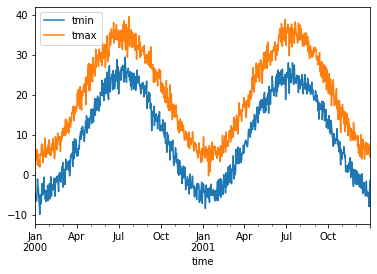

In [4]:
ds.mean(dim="location").to_dataframe().plot()

### Visualize using seaborn

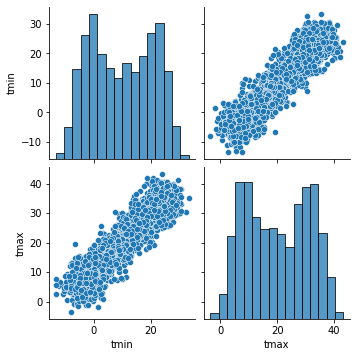

In [5]:
sns.pairplot(df.reset_index(), vars=ds.data_vars)

## Probability of freeze by calendar month

In [6]:
freeze = (ds["tmin"] <= 0).groupby("time.month").mean("time")
freeze

<xarray.DataArray 'tmin' (month: 12, location: 3)>
array([[0.9516129 , 0.88709677, 0.93548387],
       [0.84210526, 0.71929825, 0.77192982],
       [0.24193548, 0.12903226, 0.16129032],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.01612903, 0.        ],
       [0.33333333, 0.35      , 0.23333333],
       [0.93548387, 0.85483871, 0.82258065]])
Coordinates:
  * location  (location) <U2 'IA' 'IN' 'IL'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<AxesSubplot:xlabel='month'>

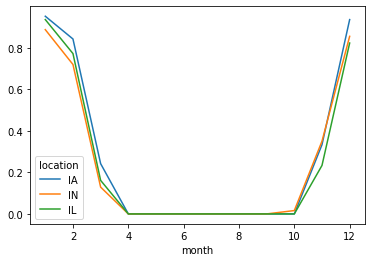

In [7]:
freeze.to_pandas().plot()

## Monthly averaging

<AxesSubplot:xlabel='time'>

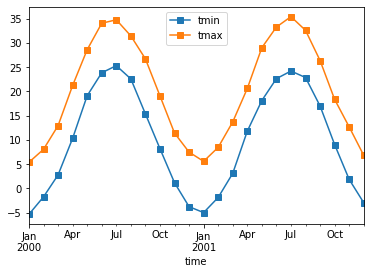

In [8]:
monthly_avg = ds.resample(time="1MS").mean()
monthly_avg.sel(location="IA").to_dataframe().plot(style="s-")

Note that ``MS`` here refers to Month-Start; ``M`` labels Month-End (the last day of the month).

## Calculate monthly anomalies

In climatology, "anomalies" refer to the difference between observations and
typical weather for a particular season. Unlike observations, anomalies should
not show any seasonal cycle.

<AxesSubplot:xlabel='time'>

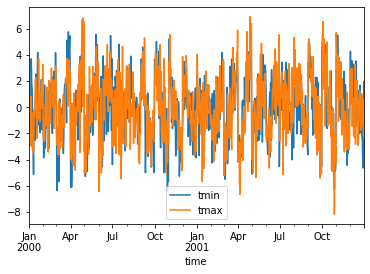

In [9]:
climatology = ds.groupby("time.month").mean("time")
anomalies = ds.groupby("time.month") - climatology
anomalies.mean("location").to_dataframe()[["tmin", "tmax"]].plot()

## Calculate standardized monthly anomalies

You can create standardized anomalies where the difference between the
observations and the climatological monthly mean is
divided by the climatological standard deviation.

<AxesSubplot:xlabel='time'>

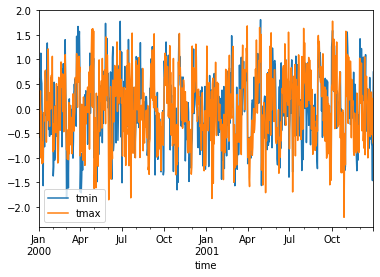

In [10]:
climatology_mean = ds.groupby("time.month").mean("time")
climatology_std = ds.groupby("time.month").std("time")
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds.groupby("time.month"),
    climatology_mean,
    climatology_std,
)

stand_anomalies.mean("location").to_dataframe()[["tmin", "tmax"]].plot()